## Analysis and comparison for Stock price sentiment for Pharma Companies vs Technology stocks.

This analysis will be done to generate investing insight by applying sentiment analysis on financial news headlines from FINVIZ.com. Using natural language processing technique, will try to understand the emotion behind the headlines and predict whether the market feels good or bad about 2 sectors in stock price. One group will hold stock prices for companies which are producing vaccines and other group will have technology companies which are going all time highs. It would then be possible to make educated guesses on how certain stocks will perform and invest accordingly.

In [24]:
# import libraries 
# create list for 2 types of stock ticker list
# For pherma companies we will use Pfizer, Moderna and Astra Zeneca and for Tech stocks we will 
# use Apple,google,amazon 

import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen
from urllib.request import Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import requests

# Parameters 
n = 3 #the # of article headlines displayed per ticker
pharma_tickers = ['PFE', 'MRNA', 'AZN','JNJ']
tech_tickers = ['AAPL', 'GOOGL', 'AMZN', 'MSFT','FB']

In [25]:
# function to get data from finviz for ticker list
def get_data(tickers):
# Get Data
    finviz_url = 'https://finviz.com/quote.ashx?t='
    news_tables = {}

    for ticker in tickers:
        url = finviz_url + ticker
        req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
        resp = urlopen(req)    
        html = BeautifulSoup(resp, features="lxml")
        news_table = html.find(id='news-table')
        news_tables[ticker] = news_table

    try:
        for ticker in tickers:
            df = news_tables[ticker]
            df_tr = df.findAll('tr')
    
            print ('\n')
            print ('Recent News Headlines for {}: '.format(ticker))
        
            for i, table_row in enumerate(df_tr):
                a_text = table_row.a.text
                td_text = table_row.td.text
                td_text = td_text.strip()
                print(a_text,'(',td_text,')')
                if i == n-1:
                    break
    except KeyError:
        pass
    
    # Iterate through the news
    parsed_news = []
    for file_name, news_table in news_tables.items():
        for x in news_table.findAll('tr'):
            text = x.a.get_text() 
            date_scrape = x.td.text.split()

            if len(date_scrape) == 1:
                time = date_scrape[0]
            
            else:
                date = date_scrape[0]
                time = date_scrape[1]

            ticker = file_name.split('_')[0]
        
            parsed_news.append([ticker, date, time, text])
    return parsed_news

In [26]:
# storing news for both in separate list
pharma_news = get_data(pharma_tickers)
tech_news = get_data(tech_tickers)



Recent News Headlines for PFE: 
AstraZeneca Covid Vaccine Appears Effective Against Brazil Variant: Report ( Mar-05-21 04:35PM )
U.S. Pushes to Reopen; Canada Clears J&J Vaccine: Virus Update ( 04:08PM )
Money worries are holding people back from getting the vaccine ( 02:13PM )


Recent News Headlines for MRNA: 
AstraZeneca Covid Vaccine Appears Effective Against Brazil Variant: Report ( Mar-05-21 04:35PM )
Money worries are holding people back from getting the vaccine ( 02:13PM )
Doctor: We may be reaching that critical point of herd immunity ( 02:11PM )


Recent News Headlines for AZN: 
AstraZeneca Covid Vaccine Appears Effective Against Brazil Variant: Report ( Mar-05-21 04:35PM )
U.S. Pushes to Reopen; Canada Clears J&J Vaccine: Virus Update ( 04:08PM )
Money worries are holding people back from getting the vaccine ( 02:13PM )


Recent News Headlines for JNJ: 
AstraZeneca Covid Vaccine Appears Effective Against Brazil Variant: Report ( Mar-05-21 04:35PM )
U.S. Pushes to Reopen; C

In [27]:
# NLTK VADER for sentiment analysis
# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
    'fail': -50
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)

In [28]:
def score_news(parsed_news):

# Use these column names
    columns = ['ticker', 'date', 'time', 'headline']
# Convert the list of lists into a DataFrame
    scored_news = pd.DataFrame(parsed_news, columns=columns)
# Iterate through the headlines and get the polarity scores
    scores = [vader.polarity_scores(headline) for headline in scored_news.headline.values]
# Convert the list of dicts into a DataFrame
    scores_df = pd.DataFrame(scores)
# Join the DataFrames
    scored_news = pd.concat([scored_news, scores_df], axis=1)
# Convert the date column from string to datetime
    scored_news['date'] = pd.to_datetime(scored_news.date).dt.date
    return scored_news

In [29]:
pharma_score_news = score_news(pharma_news)
tech_score_news = score_news(tech_news)

In [30]:
def draw_plot(scored_news):
    import matplotlib.pyplot as plt
    plt.style.use("fivethirtyeight")
    %matplotlib inline

# Group by date and ticker columns from scored_news and calculate the mean
    mean_c = scored_news.groupby(['date', 'ticker']).mean()
# Unstack the column ticker
    mean_c = mean_c.unstack(level=1)
# Get the cross-section of compound in the 'columns' axis
    mean_c = mean_c.xs('compound', axis=1)
# Plot a bar chart with pandas
    mean_c.plot.bar();

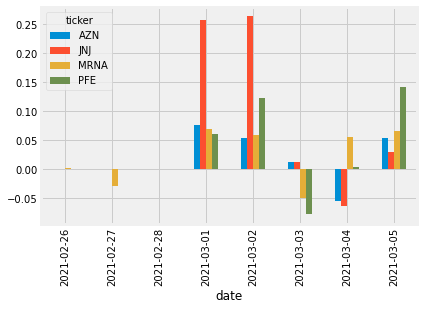

In [31]:
# drawing plot for pharma
draw_plot(pharma_score_news)

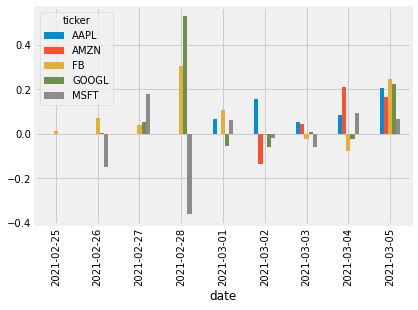

In [32]:
# drawing plot for tech
draw_plot(tech_score_news)

In [33]:
def clean_dups(scored_news):
# Count the number of headlines in scored_news (store as integer)
    num_news_before = scored_news.headline.count()
# Drop duplicates based on ticker and headline
    scored_news_clean = scored_news.drop_duplicates(['ticker', 'headline'])
# Count number of headlines after dropping duplicates
    num_news_after = scored_news_clean.headline.count()
# Compare before and after
    return scored_news_clean

In [34]:
pharma_score_news = clean_dups(pharma_score_news)

In [35]:
tech_score_news = clean_dups(tech_score_news)

In [45]:
def single_day_score(scored_news_clean,ticker):
# Set the index to ticker and date
    single_day = scored_news_clean.set_index(['ticker', 'date'])
#print(single_day)
# Cross-section the fb row
    single_day = single_day.loc[ticker]
#print(single_day)
# Select today
    single_day = single_day.loc['2021-03-05']
#print(single_day)
# Convert the datetime string to just the time
    single_day['time'] = pd.to_datetime(single_day['time'])
    single_day['time'] = single_day.time.dt.time
#print(single_day)
#print(single_day.shape)
# Set the index to time and sort by it
    single_day.set_index('time', inplace=True)
    single_day=single_day.sort_index(ascending=True)
    return single_day

In [46]:
pharma_single_day = single_day_score(pharma_score_news,'MRNA')
tech_single_day = single_day_score(tech_score_news,'AAPL')

In [47]:
def draw_plot_singleday(single_day):
    TITLE = "Positive, negative and neutral sentiment"
    COLORS = ["red", "green", "orange"]
# Drop the columns that aren't useful for the plot
    plot_day = single_day.drop(['headline', 'compound'], axis=1)
# Change the column names to 'negative', 'positive', and 'neutral'
    plot_day.columns = ['negative', 'positive', 'neutral']
# Plot a stacked bar chart
    plot_day.plot.bar(stacked = True, 
                  figsize=(10, 6), 
                  title = TITLE, 
                  color = COLORS)
    plt.legend(bbox_to_anchor=(1.2, 0.5))
    plt.ylabel("scores");

## Pharma sentiment

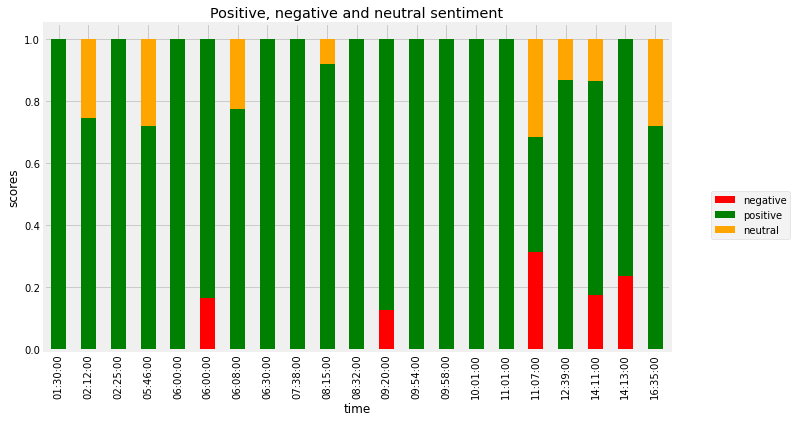

In [48]:
draw_plot_singleday(pharma_single_day)

## Tech sentiment

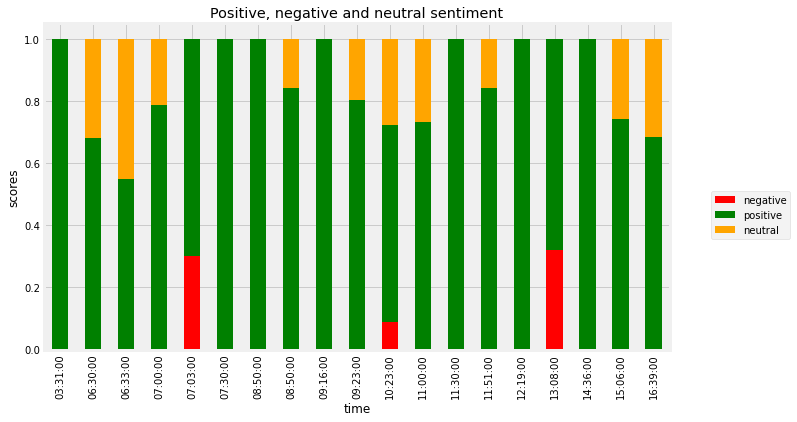

In [49]:
draw_plot_singleday(tech_single_day)

## With Sentiment analsysis collect Up-to-date Financial Ratios from FinViz 

In [41]:
import pandas as pd
import re
from bs4 import BeautifulSoup as bs
import requests
import requests
from bs4 import BeautifulSoup
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
          'Upgrade-Insecure-Requests': '1', 'Cookie': 'v2=1495343816.182.19.234.142', 'Accept-Encoding': 'gzip, deflate, sdch',
           'Referer': "http://finviz.com/quote.ashx?t="}

def get_fundamental_data(df):
    for symbol in df.index:
        try:      
            #url = ("http://finviz.com/quote.ashx?t=" + symbol.lower())
            r = requests.get("http://finviz.com/quote.ashx?t="+ symbol.lower(),headers=headers)
            soup = bs(r.content,'html.parser') 
            for m in df.columns:                
                df.loc[symbol,m] = fundamental_metric(soup,m)                
        except Exception as e:
            print (symbol, 'not found')
            print(e)
    return df


def fundamental_metric(soup, metric):
    return soup.find(text=metric).find_next(class_='snapshot-td2').text

In [42]:
stock_list = ['PFE', 'MRNA', 'AZN','AAPL', 'GOOGL', 'AMZN']

In [43]:
metric = [
'Market Cap',
'Income',
'Perf Month',
'Perf Year',
'52W Range',
'Avg Volume',
'P/B',
'P/E',
'Forward P/E',
'PEG',
'Debt/Eq',
'EPS (ttm)',
'Dividend %',
'ROE',
'ROI',
'EPS Q/Q',
'Insider Own'
]

In [44]:
df_fundamental_data = pd.DataFrame(index=stock_list,columns=metric)
df_fundamental_data = get_fundamental_data(df_fundamental_data)
df_fundamental_data

,Market Cap,Income,Perf Month,Perf Year,52W Range,Avg Volume,P/B,P/E,Forward P/E,PEG,Debt/Eq,EPS (ttm),Dividend %,ROE,ROI,EPS Q/Q,Insider Own
PFE,192.02B,9.36B,-2.26%,-0.86%,26.42 - 43.08,40.09M,2.92,20.54,11.16,3.05,0.63,1.67,4.56%,14.90%,7.60%,125.10%,0.05%
MRNA,50.18B,-747.10M,-16.57%,381.27%,19.31 - 189.26,18.40M,18.93,-,9.72,-,0.04,-1.94,-,-22.90%,-44.90%,-58.90%,2.00%
AZN,127.02B,3.20B,-5.65%,-2.82%,36.15 - 64.94,12.69M,7.94,38.81,14.74,1.92,1.30,1.22,2.96%,25.10%,12.20%,223.30%,0.50%
AAPL,2012.26B,63.93B,-11.01%,58.72%,53.15 - 145.09,108.89M,30.72,32.48,25.66,2.21,1.69,3.70,0.68%,90.60%,31.70%,34.60%,0.07%
GOOGL,1372.19B,40.27B,5.98%,47.22%,1008.87 - 2145.14,1.75M,6.17,35.64,25.05,2.10,0.07,57.07,-,19.00%,14.10%,34.70%,0.12%
AMZN,1482.06B,21.33B,-11.91%,50.70%,1626.03 - 3552.25,3.71M,15.94,71.31,44.93,1.86,0.55,41.75,-,27.10%,13.90%,117.50%,10.60%


## Feature extraction 

Feature extraction or sometimes called attribute selection aim to select features, attributes, or piece of text that is more relevant to the prediction task. Many methods have been used for feature selection. The commonly used feature selection procedure for document or sentence classification task is the bag-of-words (BOW) approach

Another important feature selection method is the latent Dirichlet allocation (LDA) technique. In the LDA model, the text is viewed as probabilistic collections of terms or words, and the collections are then treated as selected features. Other methods used a Skip-Gram model that aims to predict the context word (surrounding words) for a given target word. However, feature selection is a crucial step in the textual data preprocessing.

Another popular method used in text mining for financial application is the term frequency-inverse document frequency (TF-IDF), which is a numeric value that represents the significance of a word for a document or corpus 

## Model evaluation - ( part 3 )

From the news list i created a file to label them as positive or negetive news headline

In [170]:
with open('tech_news_file.txt', 'w') as f:
    for i in range(len(tech_news)):
        txt = tech_news[i][3]
        f.write("%s\n" % txt)

In the file each news headline has been marked as pos or neg 

In [190]:
f = open("tech_news_file1.txt", "r")
print(f.read())

pos|Apple Supplier Dialog Semi Holds Talks With Suitors Including Renesas
pos|Dow Jones Futures: Congress Fast Tracks Biden Stimulus; Market Rally Warning Signs
neg|10 Biggest Companies Competing With Netflix
pos|20 Fastest Growing Tech Cities in the World
pos|15 Biggest Canadian Software Companies
pos|3 Warren Buffett Stocks Worth Buying Now
neg|Dow Jones Futures: Coronavirus Vaccinations Hit Milestone; Market Rally Warning Signs
pos|Dow Jones Futures: Congress Fast Tracks Biden Stimulus Plan, Coronavirus Vaccinations Hit Milestone; Market Rally Warning Signs
pos|Top Apple Shareholders
pos|These Are The Best Robinhood Stocks To Buy Or Watch Now
pos|From Netflix's 'Queen's Gambit' to HBO's 'Undoing,' here's how the miniseries is leading TVs revolution
pos|Dow Jones Stocks To Buy And Watch In February 2021: AAPL Rallies On Apple Car Buzz
pos|Where to Look for the Best Electric-Vehicle Stocks Now
neg|Forget AMC! These Tech Stocks Are Better Buys Right Now
pos|Better Buy: Apple vs. Alphab

Made 2 lists 1 for labels for each news headline another for new headlines it self.

In [198]:
file1 = open('tech_news_file1.txt', 'r')
count = 0
labels = []
news = []
 
# Using for loop
print("Using for loop")
for line in file1:
    count += 1
    print("Line{}: {}".format(count, line.strip()))
    separated = line.strip().split("|")
    labels.append(separated[0])
    news.append(separated[1])
 
# Closing files
file1.close()

Using for loop
Line1: pos|Apple Supplier Dialog Semi Holds Talks With Suitors Including Renesas
Line2: pos|Dow Jones Futures: Congress Fast Tracks Biden Stimulus; Market Rally Warning Signs
Line3: neg|10 Biggest Companies Competing With Netflix
Line4: pos|20 Fastest Growing Tech Cities in the World
Line5: pos|15 Biggest Canadian Software Companies
Line6: pos|3 Warren Buffett Stocks Worth Buying Now
Line7: neg|Dow Jones Futures: Coronavirus Vaccinations Hit Milestone; Market Rally Warning Signs
Line8: pos|Dow Jones Futures: Congress Fast Tracks Biden Stimulus Plan, Coronavirus Vaccinations Hit Milestone; Market Rally Warning Signs
Line9: pos|Top Apple Shareholders
Line10: pos|These Are The Best Robinhood Stocks To Buy Or Watch Now
Line11: pos|From Netflix's 'Queen's Gambit' to HBO's 'Undoing,' here's how the miniseries is leading TVs revolution
Line12: pos|Dow Jones Stocks To Buy And Watch In February 2021: AAPL Rallies On Apple Car Buzz
Line13: pos|Where to Look for the Best Electric-V

IndexError: list index out of range

In [203]:
labels[0]

'pos'

In [204]:
news[1]

'Dow Jones Futures: Congress Fast Tracks Biden Stimulus; Market Rally Warning Signs'

#### simple bag of words model -
sentiment analyzer will be a bag-of-words model. A bag-of-words model is one in which each input (in our case, each review) is first reduced to an unordered set of the words which occur within the input.

In [206]:
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer

print(word_tokenize(news[0]))
reTokenizer = RegexpTokenizer(r'\w+')
print(reTokenizer.tokenize(news[0]))

['Apple', 'Supplier', 'Dialog', 'Semi', 'Holds', 'Talks', 'With', 'Suitors', 'Including', 'Renesas']
['Apple', 'Supplier', 'Dialog', 'Semi', 'Holds', 'Talks', 'With', 'Suitors', 'Including', 'Renesas']


#### Preparing the features - 
word_tokenize separates the review into a list of words, but considers punctuation as words. This might be desirable for some sorts of models  but for a bag-of-words model it seems like punctuation may add noise.


In [210]:
all_words = []
for i in range(len(reviews)):
    tokens = reTokenizer.tokenize(reviews[i])
    news[i] = []
    for word in tokens:
        word = word.lower
        word = lemmatizer.lemmatize(word)
        all_words.append(word)
        news[i].append(word)

 we need to collect all the words from all the reviews into one list and keep the 3000 most common words as our bag-of-words vocabulary.All our words are in the list all_words. NLTK conveniently provides functionality for extracting the most common words from a list.

In [211]:
from nltk import FreqDist

all_words = FreqDist(all_words)
most_common_words = all_words.most_common(3000)
word_features = []
for w in most_common_words:
      word_features.append(w[0])

We collect all the words into our word_features list. We can now iterate through each review in reviews and create a vector of 1's and 0's for a given review depending on which words from our list.

In [216]:
def make_feature_dict(word_list):
    feature_dict = {}
    for w in word_features:
        if w in word_list:
            feature_dict[w] = 1
        else:
            feature_dict[w] = 0
    return feature_dict

In [224]:
labels = labels[:140]
news = news[:140]

### Train set and traning set of model - and classifier

In [225]:
nltk_data_set = []
for i in range(len(labels)):
      nltk_data_set.append((make_feature_dict(news[i]), labels[i]))

train_proportion = 0.9
train_set_size = int(train_proportion * len(labels))

training_set = nltk_data_set[:train_set_size]
testing_set = nltk_data_set[train_set_size:]

In [226]:
print("Beginning classifier training...")
classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Finished classifier training... its accuracy on the testing set is: ")
print(nltk.classify.accuracy(classifier, testing_set))

print("The most informative features were: ")
classifier.show_most_informative_features(30)

Beginning classifier training...
Finished classifier training... its accuracy on the testing set is: 
0.5714285714285714
The most informative features were: 
Most Informative Features


In [227]:
import random

train_proportion = 0.9
train_set_size = int(train_proportion * len(labels))


accuracies = 0
for i in range(10):
    random.shuffle(nltk_data_set)

    training_set = nltk_data_set[:train_set_size]
    testing_set = nltk_data_set[train_set_size:]

    print("Beginning classifier training...")
    classifier = nltk.NaiveBayesClassifier.train(training_set)
    print("Finished classifier training... its accuracy on the test set is: ")
    print(nltk.classify.accuracy(classifier, testing_set))
    accuracies += nltk.classify.accuracy(classifier, testing_set)

print("Average accuracy across 10 models: ")
print(accuracies/10)

Beginning classifier training...
Finished classifier training... its accuracy on the test set is: 
0.9285714285714286
Beginning classifier training...
Finished classifier training... its accuracy on the test set is: 
0.6428571428571429
Beginning classifier training...
Finished classifier training... its accuracy on the test set is: 
0.7142857142857143
Beginning classifier training...
Finished classifier training... its accuracy on the test set is: 
0.8571428571428571
Beginning classifier training...
Finished classifier training... its accuracy on the test set is: 
0.6428571428571429
Beginning classifier training...
Finished classifier training... its accuracy on the test set is: 
0.8571428571428571
Beginning classifier training...
Finished classifier training... its accuracy on the test set is: 
0.9285714285714286
Beginning classifier training...
Finished classifier training... its accuracy on the test set is: 
0.6428571428571429
Beginning classifier training...
Finished classifier tra